# NSQIP - Single Predictors
---

Once we've selected a subpopulation of predictors. How well does each do in predicting the 5 outcomes we've selected? We'll fit a logistic regression model to each single predictor, and then plot how well each predictor does at predicting each outcome.

Begin with imports of key libraries, and load the data.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
import sklearn.metrics as sklm
import random
import warnings 
import math
# warnings.filterwarnings("ignore") # Ignore annoying warnings

dataDir = './Data/'
mungedFileName = dataDir + 'mungedData.pkl'

cdf = pd.read_pickle(mungedFileName)

Next, determine which CPT codes we'll use.

In [2]:
# CPT codes were munged to numeric values
CPTcodes = cdf.loc[:,'CPT']

# Print some data on all case categories in our dataset
print('--- Achilles operative repair ---')
keepCPT = [27650,27652,27654]
caseCounts = [(eachCPT, list(CPTcodes).count(eachCPT)) for eachCPT in keepCPT]
for aCPT, aCount in caseCounts:
    print('CPT: %d Cases: %d' % (aCPT, aCount))
print('--- Total: %d ---\n' % sum([each[1] for each in caseCounts]))
    

print('--- Calcaneus operative repair ---')
keepCPT = [28406,28415,28420] 
caseCounts = [(eachCPT, list(CPTcodes).count(eachCPT)) for eachCPT in keepCPT]
for aCPT, aCount in caseCounts:
    print('CPT: %d Cases: %d' % (aCPT, aCount))
print('--- Total: %d ---\n' % sum([each[1] for each in caseCounts]))


print('--- Ankle Fractures ---')
keepCPT = [27766, 27769, 27792, 27814, 27822, 27823, 27826, 27827, 27828, 27829]
caseCounts = [(eachCPT, list(CPTcodes).count(eachCPT)) for eachCPT in keepCPT]
for aCPT, aCount in caseCounts:
    print('CPT: %d Cases: %d' % (aCPT, aCount))
print('--- Total: %d ---\n' % sum([each[1] for each in caseCounts]))

# Choose a specific group of CPT codes to keep, and select them from the data table
keepCPT = [27766, 27769, 27792, 27814, 27822, 27823, 27826, 27827, 27828, 27829]
# keepCPT = [27650,27652,27654]
cdf = cdf.loc[cdf['CPT'].isin(keepCPT)]

--- Achilles operative repair ---
CPT: 27650 Cases: 1576
CPT: 27652 Cases: 106
CPT: 27654 Cases: 288
--- Total: 1970 ---

--- Calcaneus operative repair ---
CPT: 28406 Cases: 0
CPT: 28415 Cases: 0
CPT: 28420 Cases: 50
--- Total: 50 ---

--- Ankle Fractures ---
CPT: 27766 Cases: 688
CPT: 27769 Cases: 74
CPT: 27792 Cases: 3409
CPT: 27814 Cases: 3910
CPT: 27822 Cases: 2076
CPT: 27823 Cases: 594
CPT: 27826 Cases: 99
CPT: 27827 Cases: 561
CPT: 27828 Cases: 631
CPT: 27829 Cases: 630
--- Total: 12672 ---



Print out a list of all the potential predictor columns we could use.

In [3]:
for col in cdf.columns:
    print(col)

ADMQTR-1
ADMQTR-2
ADMQTR-3
ADMQTR-4
ADMSYR-2007.0
ADMSYR-2008.0
ADMSYR-2009.0
ADMYR-2007
ADMYR-2008
ADMYR-2009
ADMYR-2010
ADMYR-2011
ADMYR-2012
ADMYR-2013
ADMYR-2014
AGE
AIRTRA-Lip laceration or hematoma
AIRTRA-None
AIRTRA-Tooth chipped, loosened or lost
ANESTHES-Epidural
ANESTHES-General
ANESTHES-Local
ANESTHES-MAC/IV Sedation
ANESTHES-Monitored Anesthesia Care
ANESTHES-None
ANESTHES-Other
ANESTHES-Regional
ANESTHES-Spinal
ANESTHES_OTHER-Epidural
ANESTHES_OTHER-Epidural,Regional
ANESTHES_OTHER-General
ANESTHES_OTHER-Local
ANESTHES_OTHER-Local,Monitored Anesthesia Care/IV Sedation
ANESTHES_OTHER-Local,Other
ANESTHES_OTHER-Monitored Anesthesia Care/IV Sedation
ANESTHES_OTHER-Other
ANESTHES_OTHER-Regional
ANESTHES_OTHER-Regional,Local
ANESTHES_OTHER-Regional,Monitored Anesthesia Care/IV Sedation
ANESTHES_OTHER-Regional,Other
ANESTHES_OTHER-Spinal
ANESTHES_OTHER-Spinal,Epidural
ANESTHES_OTHER-Spinal,Local
ANESTHES_OTHER-Spinal,Monitored Anesthesia Care/IV Sedation
ANESTHES_OTHER-Spinal,Re

Decide which outcome we'll look at.

In [4]:
allROCs = np.zeros([5, 19])

# y is True for bad things happening.
outcomeList = ['mortality', 'major', 'minor', 'bleeding', 'readmit']
from outcomeVariables import getOutcomeVariable
fullCDF = cdf
for eachOutcomeN in range(len(outcomeList)):
    cdf = fullCDF
    yFull = getOutcomeVariable(cdf, outcomeList[eachOutcomeN])
    print(' ')
    print('# of %s: %d' % (outcomeList[eachOutcomeN], np.count_nonzero(yFull)))
    print('-------------------- ')
    
    # Drop rows with NaN outcome y data
    nanIdx = np.isnan(yFull).nonzero()
    yFull = np.delete(yFull.ravel(), nanIdx ,axis=0).reshape(-1,1)
    cdf.drop(cdf.index[nanIdx], axis=0, inplace=True)

    # Make a column for transfer from any facility
    cdf.loc[:,'TRANST-FACILITY'] = 1 - cdf.loc[:,'TRANST-Admitted directly from home'] -\
                                cdf.loc[:,'TRANST-Not transferred (admitted from home)'] -\
                                cdf.loc[:,'TRANST-Unknown']
    # Make a column for elderly
    cdf.loc[:,'ELDERLY-Yes'] = (cdf['AGE'] >= 80).astype(int)
    # Make a column for non-General Anesthesia
    cdf.loc[:,'ANESTHES-NonGA'] = 1 - cdf.loc[:,'ANESTHES-General']
    # Add a BMI column
    cdf.loc[:,'BMI'] = cdf.loc[:,'WEIGHT']*(1/2.20462)/(cdf.loc[:,'HEIGHT']*(1/39.3701)*\
                                                    cdf.loc[:,'HEIGHT']*(1/39.3701))
    # Add a all DIABETES column
    cdf.loc[:,'DIABETES-Yes'] = 1 - cdf.loc[:,'DIABETES-NO']
    # Pulmonary abnormalities, score is higher if both COPD and pneumonia
    cdf.loc[:,'PULMHX'] = cdf.loc[:,'HXCOPD-Yes'] + cdf.loc[:,'CPNEUMON-Yes']
    # Cardiac abnormalities, score is higher with multiple
    cdf.loc[:,'CARDSHX'] = cdf.loc[:,'HXCHF-Yes'] + cdf.loc[:,'HXMI-Yes'] + \
                    cdf.loc[:,'PRVPCI-Yes'] + cdf.loc[:,'PRVPCS-Yes'] + \
                    cdf.loc[:,'HXANGINA-Yes']
    # Renal abnormalities
    cdf.loc[:,'RENALHX'] = cdf.loc[:,'RENAFAIL-Yes'] + cdf.loc[:,'DIALYSIS-Yes']
    # CNS abnormalities
    cdf.loc[:,'CNSHX'] = cdf.loc[:,'HXTIA-Yes'] + cdf.loc[:,'CVA-Yes'] + cdf.loc[:,'CVANO-Yes']
    # ASA Class
    cdf.loc[:,'ASACLASS-345'] = cdf.loc[:,'ASACLAS-3-Severe Disturb'] + \
                cdf.loc[:,'ASACLAS-4-Life Threat'] + cdf.loc[:,'ASACLAS-5-Moribund']
    # Operative time
    cdf.loc[:,'LONGTIME'] = (cdf.loc[:,'OPTIME'] >= 120).astype(int)



    keepList = ['SEX-male','RACE_NEW-White','ETHNICITY_HISPANIC-Yes','TRANST-FACILITY','AGE',\
           'ELDERLY-Yes', 'ANESTHES-NonGA', 'BMI','DIABETES-Yes','ETOH-Yes','FNSTATUS2-Independent',\
           'PULMHX','CARDSHX','RENALHX', 'CNSHX','TRANSFUS-Yes','ASACLASS-345','OPTIME','LONGTIME']

    # Make a list of any column in cdf whose name starts with a string in keepList
    colsToKeep = [colName for colName in cdf.columns \
              if np.any([colName.startswith(keepItem) for keepItem in keepList])]
    cdf = cdf[colsToKeep]
    
    
    # Protect against only having one value in the columns.
    # (Imputer will drop these columns, and then we won't know the names...)
    for colName in cdf.columns:
        colData = cdf[colName]
        uniques = np.unique(colData)
        nonNanUniques = [item for item in uniques if ~np.isnan(item)]
        if len(nonNanUniques) < 2:
            print('Not enough variance, dropping column: %s' % colName)
            cdf.drop(colName, axis=1, inplace=True)

    # Impute missing data in cdf
    colNames = cdf.columns
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=True)
    imp.fit(cdf)
    X = imp.transform(cdf)
    cdf = pd.DataFrame(X, columns=colNames)
    
    # Scale the columns
    colNames = cdf.columns
    X = StandardScaler().fit_transform(cdf)
    scaledX = pd.DataFrame(X, columns=colNames)
    
    # Split for validation
    from sklearn.cross_validation import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(scaledX, yFull, test_size=0.33)
    y_train = y_train.reshape(-1,)
    y_test = y_test.reshape(-1,)
    
    for colN in range(len(colsToKeep)):
    
        lr = LogisticRegression(fit_intercept=True, penalty='l2', C=1000)
        
        yFull = yFull.reshape(yFull.shape[0],)
        scores = cross_val_score(lr, X[:,colN].reshape(-1,1), yFull, cv=3, scoring='roc_auc')
        print('%s: ROC: %.3f' % (colsToKeep[colN], scores.mean()))
        allROCs[eachOutcomeN, colN] = scores.mean()
    


 
# of mortality: 27
-------------------- 
AGE: ROC: 0.818
ETHNICITY_HISPANIC-Yes: ROC: 0.482
ETOH-Yes: ROC: 0.491
FNSTATUS2-Independent: ROC: 0.747
OPTIME: ROC: 0.515
RACE_NEW-White: ROC: 0.539
SEX-male: ROC: 0.529
TRANSFUS-Yes: ROC: 0.502
TRANST-FACILITY: ROC: 0.653
ELDERLY-Yes: ROC: 0.695
ANESTHES-NonGA: ROC: 0.445
BMI: ROC: 0.572
DIABETES-Yes: ROC: 0.552
PULMHX: ROC: 0.409
CARDSHX: ROC: 0.411
RENALHX: ROC: 0.480
CNSHX: ROC: 0.410
ASACLASS-345: ROC: 0.716
LONGTIME: ROC: 0.538
 
# of major: 361
-------------------- 
AGE: ROC: 0.642
ETHNICITY_HISPANIC-Yes: ROC: 0.506
ETOH-Yes: ROC: 0.498
FNSTATUS2-Independent: ROC: 0.556
OPTIME: ROC: 0.556
RACE_NEW-White: ROC: 0.535
SEX-male: ROC: 0.485
TRANSFUS-Yes: ROC: 0.505
TRANST-FACILITY: ROC: 0.528
ELDERLY-Yes: ROC: 0.543
ANESTHES-NonGA: ROC: 0.488
BMI: ROC: 0.550
DIABETES-Yes: ROC: 0.580
PULMHX: ROC: 0.508
CARDSHX: ROC: 0.518
RENALHX: ROC: 0.515
CNSHX: ROC: 0.500
ASACLASS-345: ROC: 0.650
LONGTIME: ROC: 0.534
 
# of minor: 243
-----------------

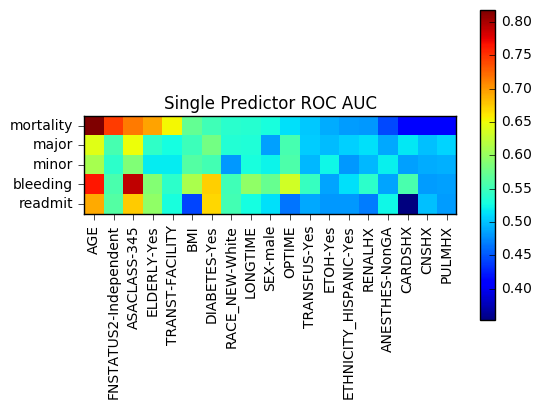

In [29]:
sortOrder = np.flipud(np.argsort(allROCs[0,:]))
sortedCols = [colsToKeep[ix] for ix in sortOrder]

imgplot = plt.imshow(allROCs[:,sortOrder],interpolation="nearest")
plt.colorbar()
plt.title('Single Predictor ROC AUC')
plt.xticks(np.arange(19), sortedCols, rotation='vertical')
plt.yticks(np.arange(5), outcomeList)
plt.tick_params(direction='out', top='off', right='off')